# Microtask: Explore Toolhub Data

## Introduction

[Toolhub](https://toolhub.wikimedia.org/) is a community-authored catalog containing 2.600+ Wikimedia tools. Technical volunteers can use Toolhub to document the tools that they create or maintain. All Wikimedians can use Toolhub to search for tools to help with their workflows and to create lists of useful tools to share with others.

In Toolhub, "tool" is an inclusive term for software applications which interact with the Wikimedia projects without being fully implemented by MediaWiki. This includes things like user scripts, gadgets, bots, templates, lua modules, web applications, and mobile apps. The catalog is intended to be inclusive rather than exclusive as long as the things it documents are useful for improving workflows and user experiences when interacting with the projects of the Wikimedia movement.

You can [read more about Toolhub on Meta Wiki](https://meta.wikimedia.org/wiki/Toolhub). You are also encouraged to explore [Toolhub's demo server](https://toolhub-demo.wmcloud.org/). Among other things, you can use it to search for tools, and create and edit your own; understanding what info is available about tools, and how it's added, edited, and displayed can help you with the tasks in this notebook. You can consider the demo server as a sandbox where you can play and explore without worrying that anything could break. 

If you click on any one tool, you will see information about it displayed. Example: [Wikidata Todo](https://toolhub.wikimedia.org/tools/mm_wikidata_todo). This information is submitted by the tool's maintainer(s) in a `toolinfo.json` file, which contains a lot of different fields; however, most of them are optional, and for this reason, much potentially useful information is missing. Missing tool information lowers Toolhub's quality as a whole, and makes tools less discoverable by the site's search and filtering functionalities. 

The good news is, some of the information contained in the toolinfo record is editable by anyone (as long as they are logged in) by clicking the "edit tool" button on the tool info page, or via the [Toolhub API](https://toolhub.wikimedia.org/api-docs). 

The aim of this Outreachy project is to create a dedicated web application for editing Toolhub records in a fun and easy way, similar to how the tool [Citation Hunt](https://citationhunt.toolforge.org/en?id=938f63ed) improves the experience of adding missing sources to Wikipedia articles. Feel free to create and edit your own "fake tools" using the demo server. This might help you understand the workflows our app will attempt to improve. 

This web application will include the following features:

* An interface for completing tasks
* A leaderboard
* Stretch goal: a dashboard, showing toolinfo completeness statistics

## Working with the Toolhub API

Using the link in the previous section, navigate to the Toolhub API docs. There are many different endpoints, grouped by functionality. Most of these will not be relevant to this project, for instance "autocomplete", "crawler", or "spdx". These, and many others, can be safely ignored.

This is an example of how to retrieve the info for a given tool.

In [2]:
import json  # will let us print out the response in a prettier format
import requests  # necessary to make API calls

# configure API session parameters

# user_agent helps identify the request if there is an issue and is best practice
REQUEST_LABEL = 'Outreachy 25 Toolhub Microtask'

# NOTE: it's considered best practice to include contact info in user agents
# I have used mine here – feel free to change it to your own
USER_INFO = 'Phabricator user: Slst2020'

headers = {'User-Agent': f'{REQUEST_LABEL} - {USER_INFO}'}

TOOLS_API_ENDPOINT = "https://toolhub.wikimedia.org/api/tools"
toolname = 'pywikibot'  # name of tool we want info about 
url = f'{TOOLS_API_ENDPOINT}/{toolname}/'

response = requests.get(url, headers=headers)
if response.status_code == 200:
    json_formatted_response = json.dumps(response.json(), indent=2)
    print(json_formatted_response)
   
else:
    print(response.status_code)

{
  "name": "pywikibot",
  "title": "Pywikibot",
  "description": "Python library and collection of scripts that automate work on MediaWiki sites",
  "url": "https://www.mediawiki.org/wiki/Special:MyLanguage/Manual:Pywikibot",
  "keywords": [],
  "author": [
    {
      "name": "Pywikibot team"
    }
  ],
  "repository": "https://gerrit.wikimedia.org/g/pywikibot/core",
  "subtitle": null,
  "openhub_id": null,
  "url_alternates": [],
  "bot_username": null,
  "deprecated": false,
  "replaced_by": null,
  "experimental": false,
  "for_wikis": [
    "*"
  ],
  "icon": "https://commons.wikimedia.org/wiki/File:Pywikibot_MW_gear_icon.svg",
  "license": "MIT",
  "sponsor": [],
  "available_ui_languages": [],
  "technology_used": [
    "python"
  ],
  "tool_type": "coding framework",
  "api_url": null,
  "developer_docs_url": [
    {
      "url": "https://www.mediawiki.org/wiki/Special:MyLanguage/Manual:Pywikibot/Development",
      "language": "en"
    }
  ],
  "user_docs_url": [
    {
     

There's quite a lot of data here! This might be a good moment for you to get familiar with the [Toolhub Data Model](https://meta.wikimedia.org/wiki/Toolhub/Data_model).

The data we are interested in is the `annotations` dict. This is the data that anyone can edit. However, if you look closely, you will see that some of the fields in "annotations", are actually present elsewhere in the data too. For instance, "repository" exists both as a top-level key, and as a key in the nested "annotations" dict. The reason for this is that Toolhub features two "layers" of tool info: The "Core" toolinfo, and the "Annotations" toolinfo.

* The **Core** tool info is the info provided by a tools maintainer(s), by way of the `toolinfo.json` file. This info is considered the ultimate source of truth, and cannot be overwritten by someone else by editing the tool.
* **Annotations** provide a way for anyone to add missing info to a tool. However, this information will be displayed *if and only if* the corresponding piece of information is missing in the Core info layer. Some fields, like for example `wikidata_qid`, exist only in the Annotations layer.
* Note that the **Core** tool info is not explicitely called "Core" in the json response from the API. You can think of all the fields that *aren't* part of the `annotations` dict as being the "Core info"

You can find some more information about Core vs Annotations in [Toolhub docs: Editing Tool info](https://meta.wikimedia.org/wiki/Toolhub#Editing_tool_info).

The conclusion is that we will consider a piece of information missing only if it is absent from both the Core *and* Annotations layers. 

## Tasks

For each of the tasks that follow, whenever you write a function, you should also write **one or more tests**, to convince yourself and the readers of this notebook that it does what it is supposed to do.

Don't get discouraged if you get stuck – you can always ask the mentors and other applicants for help in Phabricator.

**NOTE:** Many Python libraries are already available in PAWS; should you need any that isn't, you can easily install it by running `!pip install <library-name>` in a code cell.

### Task set 1

In [3]:
# TODO: Write a function that takes a tool name,
# and returns all the missing fields as a list.

def get_list_of_missing_fields(toolname):
    '''Takes in a toolname, and returns all the missing fields as a list'''
    missing_field=[]
    toolname_json= json.loads(toolname)
    print(toolname_json)
    annotation= toolname_json['annotations']
    #looping through the annotations field 
    #and appending the keys with empty or null values to "missing_field"
    for key,value in annotation.items():
        if annotation[key] == None or annotation[key]== []:
            missing_field.append(key)
    #comparing the keys in core and the missing_fields data        
    for keys, values in toolname_json.items():
        if keys in missing_field and (toolname_json[keys] != annotation[keys]):
            missing_field.remove(keys)
        
    # return the list of missing data from core and annotation
    return(missing_field)

missing_data= get_list_of_missing_fields(json_formatted_response)
print(missing_data)


#---TEST CASE---
input_tool= {
	"wikidata_qid": None,
	"deprecated": False,
    "annotations":{
        "prince": True,
        "wikidata_qid":None
    }
}

json_tool=json.dumps(input_tool, indent=2)

#selfassert test for keys in missing_data
assert 'wikidata_qid' in get_list_of_missing_fields(json_tool)





{'name': 'pywikibot', 'title': 'Pywikibot', 'description': 'Python library and collection of scripts that automate work on MediaWiki sites', 'url': 'https://www.mediawiki.org/wiki/Special:MyLanguage/Manual:Pywikibot', 'keywords': [], 'author': [{'name': 'Pywikibot team'}], 'repository': 'https://gerrit.wikimedia.org/g/pywikibot/core', 'subtitle': None, 'openhub_id': None, 'url_alternates': [], 'bot_username': None, 'deprecated': False, 'replaced_by': None, 'experimental': False, 'for_wikis': ['*'], 'icon': 'https://commons.wikimedia.org/wiki/File:Pywikibot_MW_gear_icon.svg', 'license': 'MIT', 'sponsor': [], 'available_ui_languages': [], 'technology_used': ['python'], 'tool_type': 'coding framework', 'api_url': None, 'developer_docs_url': [{'url': 'https://www.mediawiki.org/wiki/Special:MyLanguage/Manual:Pywikibot/Development', 'language': 'en'}], 'user_docs_url': [{'language': 'en', 'url': 'https://www.mediawiki.org/wiki/Special:MyLanguage/Manual:Pywikibot'}, {'url': 'https://doc.wikim

**TODO**: Consider all the fields that are editable.
1. Should they all be considered equally valuable from the point of view of a user searching for a tool to use in their workflows? 
No, They should not all be considered equally valuable from the point of view of a user searching for a tool to use in their workflows.
2. Or a user that is looking for a tool to contribute to? Why or why not? 
And they are also not to be considered equally valuable to a user looking for a tool to contribute to. The reason for this is because of functionality and loading periods. Apparently, the dictionary is filled with fields that are redundant like "replaced by" and "wikidata_qid" and these can impact the user experience.
3. Which are, according to you, the three most valuable fields? Which are the least valuable? Explain your reasoning.
The three most valuable fields are 'api_url', 'feedback_url', 'privacy_policy_url' and the least valuable is the "replaced by" and "wikidata_qid". Because we are considering only fields that are editable, only the 'api_url', 'feedback_url', 'privacy_policy_url' return feedback and data that impact user experience. The other two are simply redundant to the user and returns to meaningful data to the user.


## How much info is missing? 

So far, we have only called the `/api/tools/{toolname}/` endpoint, which gives us one tool at a time. But we can also request *all* the tools, using another of the available endpoints.

### Task set 2


[notice] A new release of pip available: 22.3 -> 22.3.1
[notice] To update, run: pip install --upgrade pip
{'name': 'socksfinder', 'title': 'socksfinder', 'description': 'Search engine for sock puppets on Wikimedia projects', 'url': 'https://socksfinder.toolforge.org/', 'keywords': [], 'author': [{'name': 'Arkanosis'}], 'repository': 'https://github.com/Arkanosis/socksfinder', 'subtitle': None, 'openhub_id': None, 'url_alternates': [], 'bot_username': None, 'deprecated': False, 'replaced_by': None, 'experimental': False, 'for_wikis': ['fr.wikipedia.org'], 'icon': None, 'license': 'ISC', 'sponsor': [], 'available_ui_languages': ['en'], 'technology_used': ['Rust'], 'tool_type': 'web app', 'api_url': None, 'developer_docs_url': [{'url': 'https://github.com/Arkanosis/socksfinder/blob/master/README.md', 'language': 'en'}], 'user_docs_url': [], 'feedback_url': [], 'privacy_policy_url': [], 'translate_url': None, 'bugtracker_url': 'https://github.com/Arkanosis/socksfinder/issues', 'annotatio

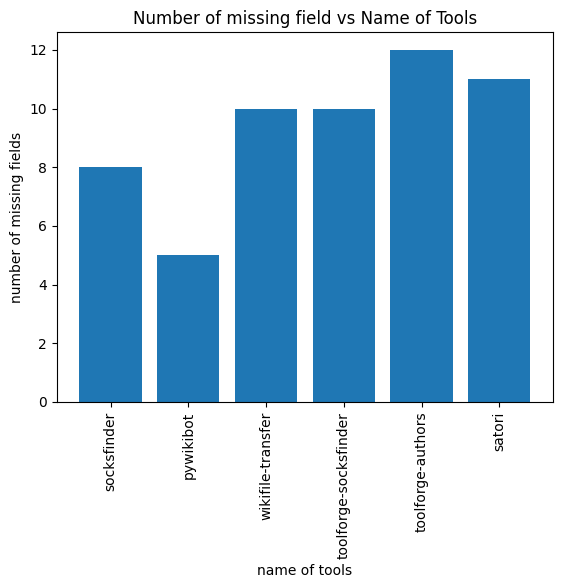

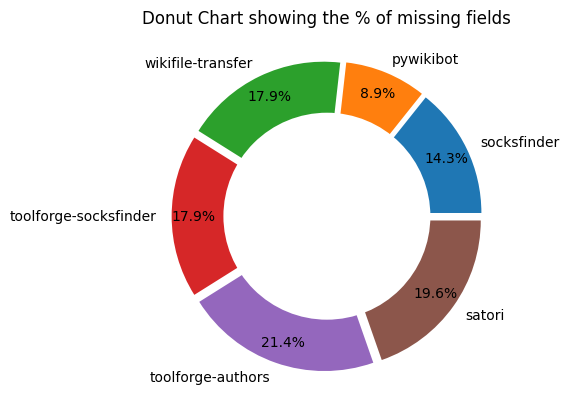

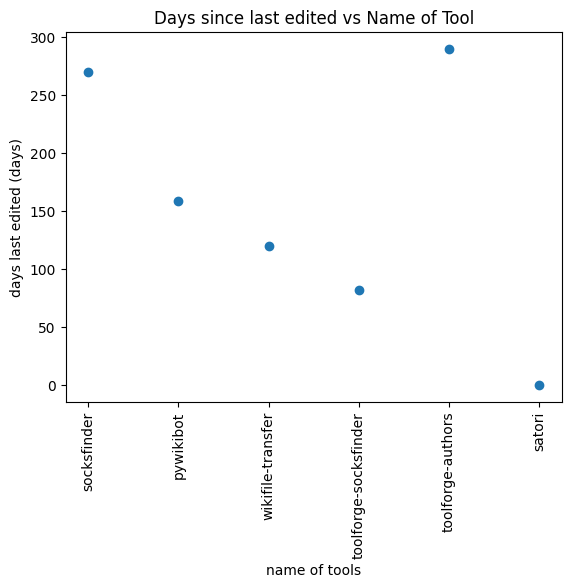

In [7]:
# TODO: Write a function that returns a dict where the keys are tool names, and the values are tuples:
# {<tool name>: (<number of missing fields>, <days since the tool was last edited>)}.


# TODO: Visualize this data in a meaningful way. 
# You can install and/or import any Python libraries you think will be useful.
# Feel free to use other fields and/or create additional visualizations!

# TODO: Which fields are most frequently missing? 
!pip install matplotlib
from matplotlib import pyplot as plt
import re
from datetime import datetime
import numpy as np

def get_toolname_and_value_tuple(list_of_tools):
    '''Takes in a toolname, and returns the missing fields and the days since the tool was last edited as a tuple'''
    required_dict_of_tools={}
    list_of_tool_values=[]
    toolname_json= json.loads(list_of_tools)
    list_of_null_fields= get_list_of_missing_fields(list_of_tools)
    number_of_missing_tool=len(list_of_null_fields)
    #looping through the json file and mapping the name to the keys in the json file
    for keys in toolname_json:
        if keys == "name":
            name_of_tool=toolname_json[keys]
        elif keys== "modified_date":
            modified_date= toolname_json[keys]
        elif keys == "created_date":
            created_date= toolname_json[keys]
   
    new_modified_date= re.search(r'\d{4}-\d{2}-\d{2}', modified_date)
    new_created_date = re.search(r'\d{4}-\d{2}-\d{2}', created_date)
    formatted_modified_date = datetime.strptime(new_modified_date.group(), '%Y-%m-%d').date()
    formatted_created_date= datetime.strptime(new_created_date.group(), '%Y-%m-%d').date()
    # using the busday_count method to count the number of valid days between formatted_created_date and formatted_modified_date
    #but not including the endday of formatted_modified_date.
    number_of_days= np.busday_count(formatted_created_date, formatted_modified_date)
    #appending the modified result to list_of_tool_values
    list_of_tool_values.append(number_of_missing_tool)
    list_of_tool_values.append(number_of_days)
    required_dict_of_tools[name_of_tool]=tuple(list_of_tool_values)
    return(required_dict_of_tools)


##here, we will dynamically assign the values to data sets
TOOLS_API_ENDPOINT = "https://toolhub.wikimedia.org/api/tools"
number_of_missing_field=[]
tool_name=[]
days_tools_last_edited=[]
toolname = ['socksfinder', 'pywikibot', 'wikifile-transfer', 'toolforge-socksfinder','toolforge-authors', 'satori']  # name of tool we want info about
for tool_name_endpoint in toolname: 
    url = f'{TOOLS_API_ENDPOINT}/{tool_name_endpoint}/'
    response = requests.get(url, headers=headers)
    if response.status_code == 200:
        tool_details = json.dumps(response.json(), indent=2)
        result_from_tool_details= get_toolname_and_value_tuple(tool_details)
        for output in result_from_tool_details:
            tool_name.append(output)
            value=result_from_tool_details[output]
            number_of_missing_field.append(value[0])
            days_tools_last_edited.append(value[1])
    else:
        print(response.status_code)

#The seven(7) toolnames whose data will be visualize are:
#'socksfinder', 'pywikibot', 'wikifile-transfer', 'toolforge-socksfinder', 'toolforge-zhmrbot', 'toolforge-authors', 'satori' in the listed order

# Function to plot a bar graph visualization
plt.bar(tool_name, number_of_missing_field)
# Adding Title
plt.title("Number of missing field vs Name of Tools")
# Labeling the axes
plt.xlabel("name of tools")
plt.ylabel("number of missing fields")
plt.xticks(rotation=90)

plt.show()


# explosion
explode = (0.05, 0.05, 0.05, 0.05, 0.05,0.05)
  
# Pie Chart
plt.pie(number_of_missing_field,labels=tool_name,
        autopct='%1.1f%%', pctdistance=0.85,
        explode=explode)
#adding a titile to the donut chart
plt.title("Donut Chart showing the % of missing fields")
# draw circle
centre_circle = plt.Circle((0, 0), 0.70, fc='white')
fig = plt.gcf()
  
# Adding Circle in Pie chart
fig.gca().add_artist(centre_circle)

 
# function to display the plot
plt.show()

# Function to plot a bar chart visualization
plt.scatter(tool_name,days_tools_last_edited )
# Adding Title
plt.title("Days since last edited vs Name of Tool")
# Labeling the axes
plt.xlabel("name of tools")
plt.ylabel("days last edited (days)")
plt.xticks(rotation=90) 
# function to display the plot
plt.show()


Another way to find tools with missing info is via the "missing" facet in search results. 

* This link will take you to a page with search results corresponding to a search for "all the tools" https://toolhub.wikimedia.org/search?ordering=-score&page=1&page_size=12
* Observe the left side of the screen, where there is a list of search facets. The first is called "Tool type", and you can see that there are 1600+ tools missing this info
* This "missing" facet can be retrieved from the `/api/search/tools` endpoint. Go back to the [API docs](https://toolhub.wikimedia.org/api-docs), and play around with this endpoint until you feel you understand it. You can also perform various searches in Toolhub, each time observing the results you get, and the query parameters in your browser's search bar. Similarly, if you are comfortable with your browser's developer tools, you can use these to observe the HTTP requests and responses.

### Task set 3

In [55]:
# TODO: Just as in task set 1, write a function that takes a tool name,
# and returns all the missing fields as a list. However this time,
# use the /api/search/tools endpoint.
import requests

def get_list_of_missing_data(toolname):
    '''Takes in a toolname, and returns all the missing fields as a list'''
    response = requests.get(f"https://toolhub.wikimedia.org/api/search/tools/{toolname}/")
    if response.status_code == 200:
        toolname_json= json.dumps(response.json(), indent=2)
        list_of_null_fields=get_list_of_missing_fields(toolname_json)
        print(list_of_null_fields)
    else:
        print("ERR: You have entered an invalid toolname")
    
get_list_of_missing_data('pywikibot')

#---TEST CASE---
input_tool= {
	"wikidata_qid": None,
	"deprecated": False,
    "annotations":{
        "prince": True,
        "wikidata_qid":None
    }
}

json_tool=json.dumps(input_tool, indent=2)

# selfassert test for keys in missing_data
print(get_list_of_missing_data(json_tool))

# According to you, which of the two endpoints is most suitable
# for retrieving missing records, and why? 
'''I believe /api/search/tools is a more suitable endpoint than api/tools/ when the user is searching for high quality filtered and specific results. However, the api/tools/ contains unfiltered results that can be suitable for more generic purposes.'''

ERR: You have entered an invalid toolname
ERR: You have entered an invalid toolname
None


'I believe /api/search/tools is a more suitable endpoint than api/tools/ when the user is searching for high quality filtered and specific results. However, the api/tools/ contains unfiltered results that can be suitable for more generic purposes.'

## Implementation details

The web application will present users with small tasks, such as "This tool is missing a link to its source code, can you find one?" These tasks will be sourced from a task queue, in which the tasks are ideally ordered from most to least "important".

**TODO**: Reflect on the following questions, and try to answer them to the best of your ability. These are open-ended questions and there's likely more than one good way to do things. Explaining your reasoning and discussing the pros and cons of different approaches is more important than arriving at the "right" answer.

### Task set 4

1. How should we define "important"? In other words, according to what criteria do you think priority in the task queue should be established?
Priority in task queue should be established on impact on functionality of the application/website, avoidng competing priorities, urgency and readability with preference given in stated order.
2. The user should have the option to skip a task and move on to the next one. A reason for skipping could be that the user tried to find the requested information, but failed. Do you think we should gather this information, for instance by having the user check a box indicating their "skip reason" before being able to click skip? What other possible skip reasons could you think of. Could this information be useful when deciding which tasks to show to which users, when to show a given task again, etc.?
Yes, the information should be collected with the users consent and can be used to improve the user's experience and expand the information database. Other reasons why users might skip a task and move to the next one includes lack of readilbility, slow execution, or no output.
3. If more than one user is connected to the application and working on tasks at the same time, how would you make sure they are not presented with the same tasks? 
I would apply locking protocols to ensure concurrency